# Systematic Trading - Deep Learning
---
 
 
- Copyright (c) Imperial College London, 2024. All rights reserved

- Author: Lukas Gonon <l.gonon@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.8



## Software check

#### Alternative 1:

Manage your local installation e.g. using Anaconda navigator. In that case you'll need to install the packages below. To check you have succesfully installed them, you can run the following cells:

In [1]:
import tensorflow.keras as keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
! pip install yfinance
import pandas as pd
import numpy as np

import torch

import random
import sklearn

import seaborn
import yfinance as yf

from tqdm import tqdm

If you can't download some of the packages via anaconda navigator, you can use:

In [4]:
import statsmodels.formula.api as smf
import seaborn as sns

#### Alternative 2:

Use google colab. You can simply log into a google account, upload the jupyter notebooks to google colab and run them online. One drawback is that the runtime is limited, sometimes you may lose connection to the kernel (so that you need to re-run the code).

To work with the provided data you'll need to use one of the methods explained here:

https://colab.research.google.com/notebooks/io.ipynb


One method that works quite smoothly is to use the following code snipet:

In [5]:
## When running on colab, upload of data works best by activating this celL:
if False:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))

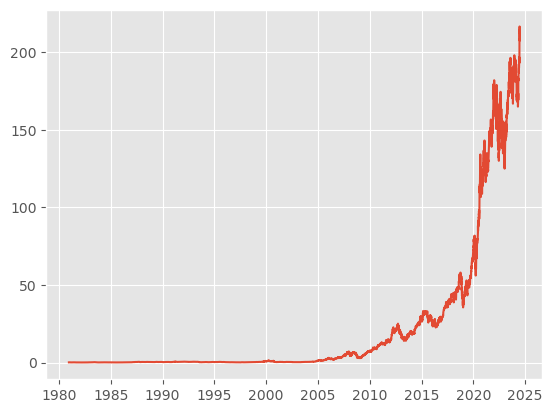

In [6]:
apple_ticker = yf.Ticker("AAPL")
apple_hist = apple_ticker.history(period="max")
plt.plot(apple_hist["Close"], label="AAPL")

# candlestick plot
import plotly.graph_objects as go
fig = go.Figure(data=[go.Candlestick(x=apple_hist.index,
                open=apple_hist['Open'],
                high=apple_hist['High'],
                low=apple_hist['Low'],
                close=apple_hist['Close'])])
fig.show()





In [7]:
# make function
def get_stock_data(ticker, start_date, end_date):
    ticker = yf.Ticker(ticker)
    hist = ticker.history(start=start_date, end=end_date)
    return hist

def draw_candlestick(hist):
    fig = go.Figure(data=[go.Candlestick(x=hist.index,
                    open=hist['Open'],
                    high=hist['High'],
                    low=hist['Low'],
                    close=hist['Close'])])
    fig.show()


In [8]:
spx_hist = get_stock_data('000001.SS', '2020-01-01', '2024-05-01')
draw_candlestick(spx_hist)

In [9]:
data_spx = yf.download("^SP500TR", start="2000-01-01", end="2020-01-01")
data_spx.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,2002.109985,2002.109985,2002.109985,2002.109985,2002.109985,0
2000-01-04,1925.410034,1925.410034,1925.410034,1925.410034,1925.410034,0
2000-01-05,1929.280029,1929.280029,1929.280029,1929.280029,1929.280029,0
2000-01-06,1931.510010,1931.510010,1931.510010,1931.510010,1931.510010,0
2000-01-07,1983.829956,1983.829956,1983.829956,1983.829956,1983.829956,0


In [10]:
import os

In [11]:
directory = os.path.join(os.getcwd(), "data_Tuesday")
sp500_prices_data = os.path.join(directory, "sp500_prices_2010_2024.csv")
data = pd.read_csv(sp500_prices_data, index_col=0)
print(data.info())
print(data.head(2))

<class 'pandas.core.frame.DataFrame'>
Index: 3585 entries, 2010-01-04 to 2024-04-02
Columns: 787 entries, A to ZTS
dtypes: float64(787)
memory usage: 21.6+ MB
None
                 A  AABA    AAL     AAP   AAPL  ABBV  ABC  ABMD  ABNB     ABT  \
TS                                                                              
2010-01-04  20.122   NaN  4.497  36.130  6.471   NaN  NaN  8.74   NaN  18.952   
2010-01-05  19.904   NaN  5.006  35.916  6.482   NaN  NaN  8.53   NaN  18.799   

            ...     XOM    XRAY     XRX  XTO  XYL     YUM     ZBH   ZBRA  \
TS          ...                                                            
2010-01-04  ...  40.238  31.596  13.919  NaN  NaN  19.064  52.587  28.67   
2010-01-05  ...  40.395  31.220  13.935  NaN  NaN  18.999  54.252  28.62   

              ZION  ZTS  
TS                       
2010-01-04  10.391  NaN  
2010-01-05  10.757  NaN  

[2 rows x 787 columns]


to do linear regression using factors such as momentum, value, quality, size, and volatility, we need to first form a factor portfolio. We can do this by ranking stocks based on each factor and then taking a long position in the top 10% of stocks and a short position in the bottom 10% of stocks. We can then combine these factor portfolios to form a multi-factor portfolio. We can then use this multi-factor portfolio to do linear regression to estimate the factor exposures of the portfolio.

# Introduction

risk-reward factor: compare a stategy's expected excess return Et-1[Rt+1] to the corresponding risk.

most well-known example: Sharpe Ratio(SR) = E(t-1)[Rt - Rf] / std(t-1)[Rt - Rf]

where Rf is the risk-free rate. the higher the sharpe ratio, the better the strategy.

suppose we start from wealth W, instead only investing in our strategy: we borrow an additional amount W at the risk-free rate, invest 2W in the strategy. we will earn E(t-1)[Rt+1] * 2W. we will have to pay back the borrowed amount W at the risk-free rate. the net profit is E(t-1)[Rt+1] * W. the sharpe ratio is the ratio of the expected excess return of the strategy to the standard deviation of the excess return of the strategy.

many dont like sharpe ratio because not all return are over the risk-free rate. we can also use information ratio: IR = E(t-1)[Rt - Rb] / std(t-1)[Rt - Rb]

where Rb is the return of a benchmark.

IR is the ratio of the expected excess return of the strategy over the benchmark to the standard deviation of the excess return of the strategy over the benchmark.

## Trading Signals
we look for signals that predict future returns. If this works, we can buy stocks with high expected returns and sell stocks with low expected returns. if not we do not do any active trading.

avoid data overfitting and data mining bias, and ensure robustness of the signals.



# Ingredients for systematic trading

## risk model
- picking up nickels in front of the steamroller: we want to avoid large losses
- attributed to an external moeny manager who warned heads of Long-Term Capital Management (LTCM) about the risks of their strategy because of the high leverage they were using. LTCM went bankrupt in 1998.

## trading costs
- third ingredient: trading costs in implementing trades: commissions, market impact, bid-ask spread, and market liquidity. people who successfully trade on paper often fail in practice because of trading costs.
- chatgpt analyse news pieces from internet to predict stock prices, with no trascaction costs, it would have 300% return, the return goes down tremendously when transaction costs are included.

- but the trascation cost does not kill all trading strategies. some strategies are profitable even after transaction costs. the key is to have a good risk model and a good trading strategy.

- trade less and only if it really worth it. need to solve dynamic optimization problem, which can be done using reinforcement learning or deep learning.

summary: some examples for the ingredients of systematic trading are: trading signals, risk model, and trading costs.

For monday, we go deep down to the trading signals.

## overfitting
when fitting to the same data, more complex models always do better. but they do not necessarily do better on new data. we need to avoid overfitting. we can do this by using a validation set, cross-validation, or regularization.

underfitting vs good fit vs overfitting

we analyse the error against both the validation set and training set. if the error is high on both, we have underfitting. if the error is low on the training set but high on the validation set, we have overfitting. if the error is low on both, we have a good fit, this is the sweet spot, which we want to achieve.

## Equities valuation and investment
VALUE
warren buffett: intrinsic value of a stock is the present value of the future cash flows of the stock discounted at the appropriate discount rate. the discount rate is the risk-free rate plus a risk premium. the risk premium is the expected excess return of the stock over the risk-free rate.

Estimate fundamental value: "Dividend discount model" (DDM)
- the value of a stock is the present value of the future dividends of the stock.

alternative: compare accounting data to market prices: book value vs market value. buy stocks with a high book value compared to their market value.

## value investing
buy stocks that are undervalued and sell stocks that are overvalued.
go against the conventional wisdom:
- assets are often expensive for a reason
- there is something other investors love about expensive stocks, and that makes them uneasy about cheap stocks.

## momentum investing
trend-following/momentum:
- buy stocks that have gone up in the past and sell stocks that have gone down in the past.
- no additional accounting data, just price history
- typical trading indicator is moving average of past stock returns: MA(t) = 1/n * sum(i=t-n+1 to t) Ri where n is the lookback period.
- some also use exponential moving average: EMA(t) = alpha * Ri + (1-alpha) * EMA(t-1) where alpha is a parameter between 0 and 1. this discounts older returns more than the simple moving average.

efficient market hypothesis: stock prices already reflect all information available in the market. if this is true, we cannot predict future stock prices. but if this is true, why do we have momentum in stock prices?
this is because market is not fully efficient. various forms of momentum are one of the most commonly used strategies to try to exploit this.
underlying economic mechanism:
- initial underreacrion to news
- evaluation of news
- overreaction to news

simple linear prediction model:
Rt = alpha + beta * Rt-1 + epsilon_t
where Rt is the return of the stock at time t, Rt-1 is the return of the stock at time t-1, epsilon_t is the error term, alpha is the intercept, and beta is the slope. lookback period N is a hyperparameter that must be chosen somewhat aribitrarily.

time-series momentum: exploit trends in the time then average across stocks. 
cross-sectional momentum: exploit trends in the cross-section of stocks at a given time. first sort stocks based on past returns, then buy the top decile and sell the bottom decile. equal weighted portfolio of 10% of most sucessful stocks and 10% of least successful stocks. long-short portfolio hedged against market risk. Average over several stocks leads to more stable performance. (look Jedadeesh and Titman 1993).

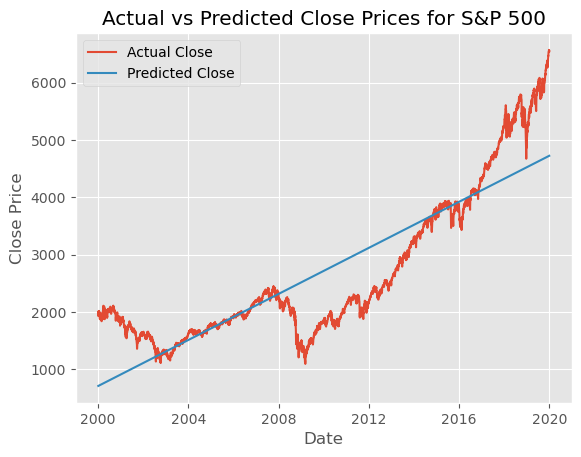

In [12]:
# Ensure the 'Date' column is the index and in datetime format
data_spx.index = pd.to_datetime(data_spx.index)

# Convert 'Date' index to numeric format for regression
data_spx['Date_ordinal'] = data_spx.index.map(pd.Timestamp.toordinal)

# Fit the linear regression model
model_market_prediction = smf.ols("Close ~ Date_ordinal", data=data_spx)
model_market_prediction = model_market_prediction.fit()

# Predict using the model
data_spx['Predicted_Close'] = model_market_prediction.predict(data_spx)

# Plot the actual and predicted values
sns.lineplot(data=data_spx, x=data_spx.index, y='Close', label='Actual Close')
sns.lineplot(data=data_spx, x=data_spx.index, y='Predicted_Close', label='Predicted Close')

# Show the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices for S&P 500')
plt.legend()
plt.show()




In [44]:
def data_import(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

def process_date(data):
    data.index = pd.to_datetime(data.index)
    data['Data_ordinal'] = data.index.map(pd.Timestamp.toordinal) # Convert 'Date' index to numeric format for regression
    return data

def fit_linear_regression(data):
    model = smf.ols("Close ~ Data_ordinal", data=data)
    model = model.fit()
    return model

def predict(model, data):
    data['Predicted_Close'] = model.predict(data)
    return data

def plot_actual_vs_predicted(data, ticker):
    sns.lineplot(data=data, x=data.index, y='Close', label='Actual Close', color='green')
    sns.lineplot(data=data, x=data.index, y='Predicted_Close', label='Predicted Close', color='red')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'Actual vs Predicted Close Prices {ticker}')
    plt.legend()
    plt.show()
    


def main_drawing_linear_regression(ticker, start_date, end_date):
    data = data_import(ticker, start_date, end_date)
    data = process_date(data)
    model = fit_linear_regression(data)
    data = predict(model, data)
    plot_actual_vs_predicted(data, ticker)




[*********************100%%**********************]  1 of 1 completed


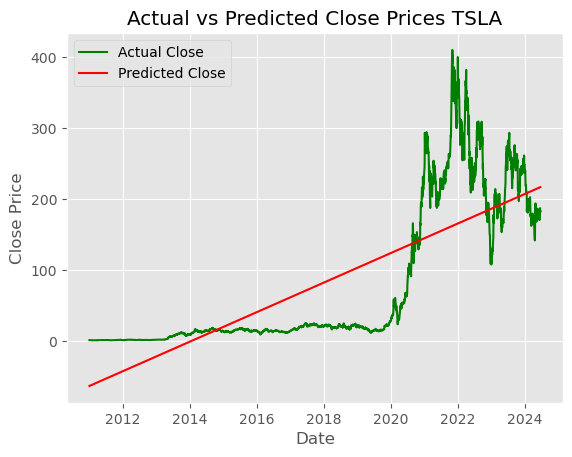

In [45]:
main_drawing_linear_regression('TSLA', '2011-01-01', '2024-06-24')